## STEP 1 : IMPORTING THE LIBRARIES

In [6]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil import parser
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

import warnings
warnings.filterwarnings("ignore")

import joblib


## STEP 2 : LOADING THE DATASETS

In [8]:
df = pd.read_excel("Flight_Fare.xlsx") 

## STEP 3 : BASIC CHECKS

In [10]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [11]:
df.shape

(10683, 11)

In [12]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [31]:
##normalize column names
df.columns = [c.strip().replace(" ", "_").replace(":", "_") for c in df.columns]


In [33]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [35]:
## if Route/Total_Stops missing only a few rows, drop them
print("Missing before:", df[['Route','Total_Stops']].isna().sum())
df.dropna(subset=['Route','Total_Stops'], inplace=True)
print("Missing after:", df[['Route','Total_Stops']].isna().sum())


Missing before: Route          1
Total_Stops    1
dtype: int64
Missing after: Route          0
Total_Stops    0
dtype: int64


In [37]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

## STEP 4 : DATA CLEANING AND PREPROCESSING

In [39]:
##date parsing
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], dayfirst=True, errors='coerce')
df['Journey_Day'] = df['Date_of_Journey'].dt.day
df['Journey_Month'] = df['Date_of_Journey'].dt.month
df['Journey_Year'] = df['Date_of_Journey'].dt.year


In [41]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,2019
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5,2019
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6,2019
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5,2019
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3,2019


In [45]:
##parse departure time (robust)
def parse_time_any(x):
    try:
        return parser.parse(str(x), fuzzy=True)
    except:
        return pd.NaT

df['Dep_Time_parsed'] = df['Dep_Time'].apply(parse_time_any)
df['Dep_Hour'] = df['Dep_Time_parsed'].dt.hour
df['Dep_Minute'] = df['Dep_Time_parsed'].dt.minute


In [47]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year,Dep_Time_parsed,Dep_Hour,Dep_Minute
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,2019,2025-12-16 22:20:00,22,20
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5,2019,2025-12-16 05:50:00,5,50
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6,2019,2025-12-16 09:25:00,9,25
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5,2019,2025-12-16 18:05:00,18,5
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3,2019,2025-12-16 16:50:00,16,50


In [49]:
##arrival time - robust parse then keep only hour/minute
df['Arrival_Time_parsed'] = df['Arrival_Time'].apply(parse_time_any)

# If some Arrival_Time were pure durations or different, try extracting HH:MM substrings:
import re
def extract_time_substring(x):
    x = str(x)
    m = re.search(r'\b(\d{1,2}:\d{2}\s?[APMapm]{0,2})\b', x)
    return m.group(1) if m else np.nan

mask_missing = df['Arrival_Time_parsed'].isna()
df.loc[mask_missing, 'Arrival_Time_sub'] = df.loc[mask_missing, 'Arrival_Time'].apply(extract_time_substring)
df.loc[mask_missing, 'Arrival_Time_parsed'] = pd.to_datetime(df.loc[mask_missing, 'Arrival_Time_sub'], errors='coerce', format='%H:%M')

# Final hour/minute
df['Arrival_Hour'] = df['Arrival_Time_parsed'].dt.hour
df['Arrival_Minute'] = df['Arrival_Time_parsed'].dt.minute

# If there remain any null arrival hours (very few), drop those rows:
print("Arrival hour nulls:", df['Arrival_Hour'].isna().sum())
df.dropna(subset=['Arrival_Hour'], inplace=True)


Arrival hour nulls: 0


In [51]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,Journey_Day,Journey_Month,Journey_Year,Dep_Time_parsed,Dep_Hour,Dep_Minute,Arrival_Time_parsed,Arrival_Time_sub,Arrival_Hour,Arrival_Minute
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,...,24,3,2019,2025-12-16 22:20:00,22,20,2025-03-22 01:10:00,NaN,1,10
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,...,1,5,2019,2025-12-16 05:50:00,5,50,2025-12-16 13:15:00,NaN,13,15
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,...,9,6,2019,2025-12-16 09:25:00,9,25,2025-06-10 04:25:00,NaN,4,25
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,...,12,5,2019,2025-12-16 18:05:00,18,5,2025-12-16 23:30:00,NaN,23,30
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,...,1,3,2019,2025-12-16 16:50:00,16,50,2025-12-16 21:35:00,NaN,21,35


In [53]:
##duration -> minutes
def duration_to_mins(x):
    s = str(x).lower().strip()
    if s == 'nan' or s == '':
        return np.nan
    h = 0; m = 0
    if 'h' in s:
        try:
            h_part = s.split('h')[0].strip()
            h = int(h_part)
        except:
            h = 0
    if 'm' in s:
        try:
            m_part = s.split('h')[-1].replace('m','').strip()
            m = int(m_part) if m_part else 0
        except:
            m = 0
    return h*60 + m

df['Duration_mins'] = df['Duration'].apply(duration_to_mins)


In [55]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,Journey_Month,Journey_Year,Dep_Time_parsed,Dep_Hour,Dep_Minute,Arrival_Time_parsed,Arrival_Time_sub,Arrival_Hour,Arrival_Minute,Duration_mins
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,...,3,2019,2025-12-16 22:20:00,22,20,2025-03-22 01:10:00,NaN,1,10,170
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,...,5,2019,2025-12-16 05:50:00,5,50,2025-12-16 13:15:00,NaN,13,15,445
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,...,6,2019,2025-12-16 09:25:00,9,25,2025-06-10 04:25:00,NaN,4,25,1140
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,...,5,2019,2025-12-16 18:05:00,18,5,2025-12-16 23:30:00,NaN,23,30,325
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,...,3,2019,2025-12-16 16:50:00,16,50,2025-12-16 21:35:00,NaN,21,35,285


In [57]:
##stops -> numeric safely
def stops_to_int(s):
    if pd.isnull(s): 
        return np.nan
    s = str(s).lower().strip()
    if 'non' in s:
        return 0
    try:
        return int(s.split()[0])
    except:
        return np.nan

df['Total_Stops_num'] = df['Total_Stops'].apply(stops_to_int)


In [59]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,Journey_Year,Dep_Time_parsed,Dep_Hour,Dep_Minute,Arrival_Time_parsed,Arrival_Time_sub,Arrival_Hour,Arrival_Minute,Duration_mins,Total_Stops_num
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,...,2019,2025-12-16 22:20:00,22,20,2025-03-22 01:10:00,NaN,1,10,170,0
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,...,2019,2025-12-16 05:50:00,5,50,2025-12-16 13:15:00,NaN,13,15,445,2
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,...,2019,2025-12-16 09:25:00,9,25,2025-06-10 04:25:00,NaN,4,25,1140,2
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,...,2019,2025-12-16 18:05:00,18,5,2025-12-16 23:30:00,NaN,23,30,325,1
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,...,2019,2025-12-16 16:50:00,16,50,2025-12-16 21:35:00,NaN,21,35,285,1


In [61]:
## route segments
df['Route_Segments'] = df['Route'].apply(lambda x: len(str(x).replace('->','→').split('→')) if pd.notnull(x) else np.nan)


In [63]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,Dep_Time_parsed,Dep_Hour,Dep_Minute,Arrival_Time_parsed,Arrival_Time_sub,Arrival_Hour,Arrival_Minute,Duration_mins,Total_Stops_num,Route_Segments
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,...,2025-12-16 22:20:00,22,20,2025-03-22 01:10:00,NaN,1,10,170,0,2
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,...,2025-12-16 05:50:00,5,50,2025-12-16 13:15:00,NaN,13,15,445,2,4
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,...,2025-12-16 09:25:00,9,25,2025-06-10 04:25:00,NaN,4,25,1140,2,4
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,...,2025-12-16 18:05:00,18,5,2025-12-16 23:30:00,NaN,23,30,325,1,3
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,...,2025-12-16 16:50:00,16,50,2025-12-16 21:35:00,NaN,21,35,285,1,3


In [65]:
##remove helper columns we don't need
cols_to_drop = ['Dep_Time_parsed','Arrival_Time_parsed','Arrival_Time_sub']
for c in cols_to_drop:
    if c in df.columns:
        df.drop(columns=c, inplace=True)


In [67]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,Journey_Day,Journey_Month,Journey_Year,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_mins,Total_Stops_num,Route_Segments
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,...,24,3,2019,22,20,1,10,170,0,2
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,...,1,5,2019,5,50,13,15,445,2,4
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,...,9,6,2019,9,25,4,25,1140,2,4
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,...,12,5,2019,18,5,23,30,325,1,3
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,...,1,3,2019,16,50,21,35,285,1,3


In [69]:
##final missing check
print(df.isna().sum())

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
Journey_Day        0
Journey_Month      0
Journey_Year       0
Dep_Hour           0
Dep_Minute         0
Arrival_Hour       0
Arrival_Minute     0
Duration_mins      0
Total_Stops_num    0
Route_Segments     0
dtype: int64


## STEP 5 : EDA

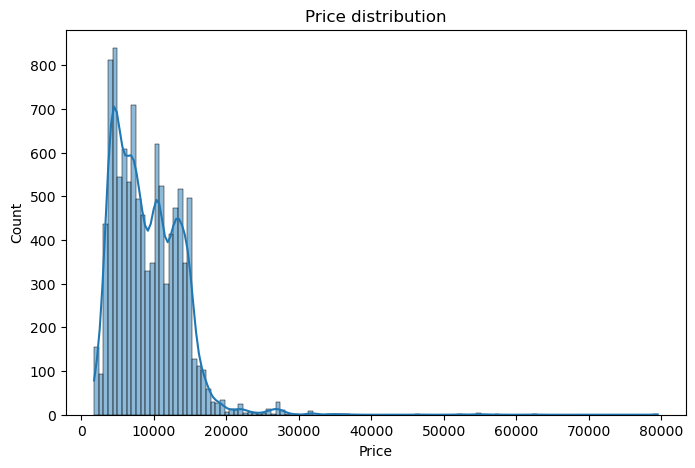

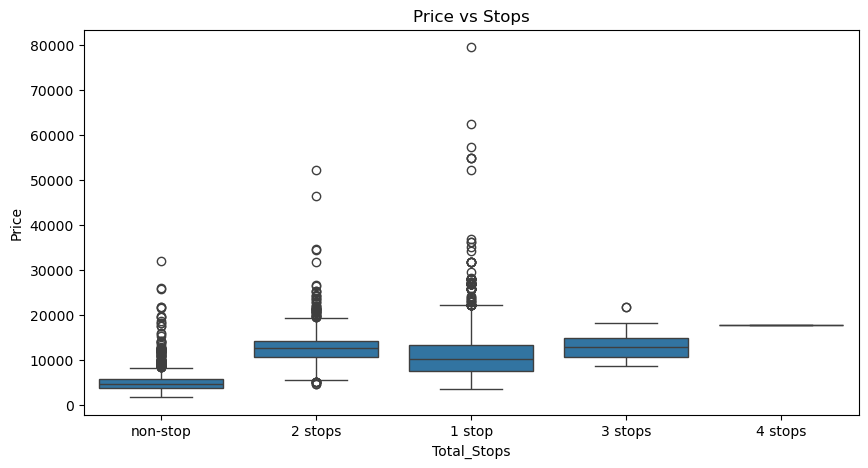

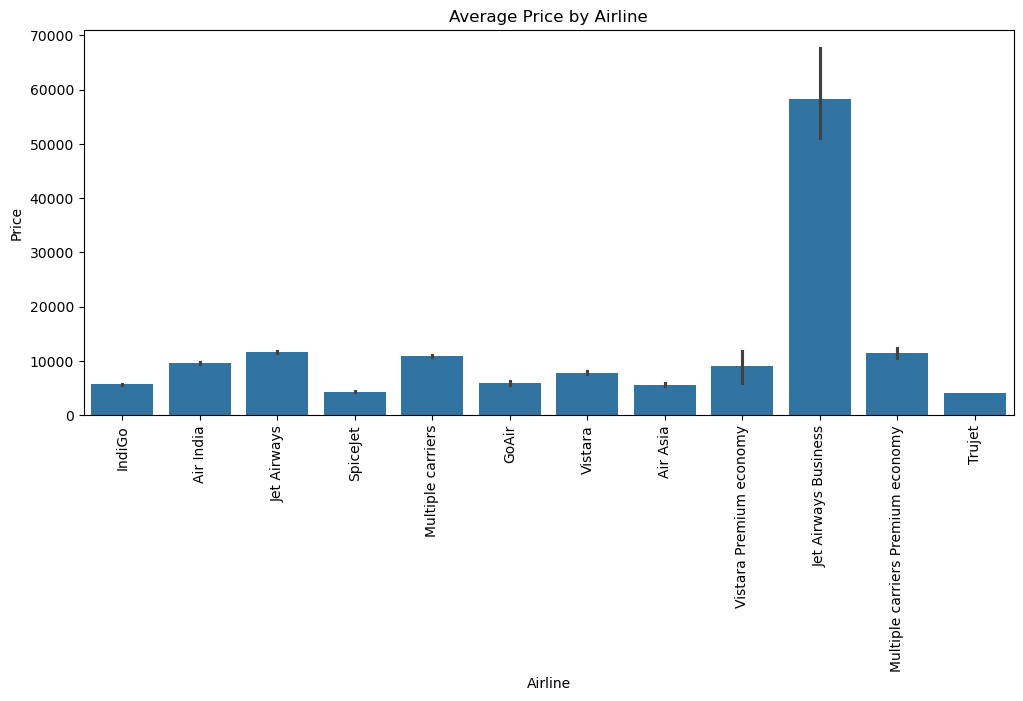

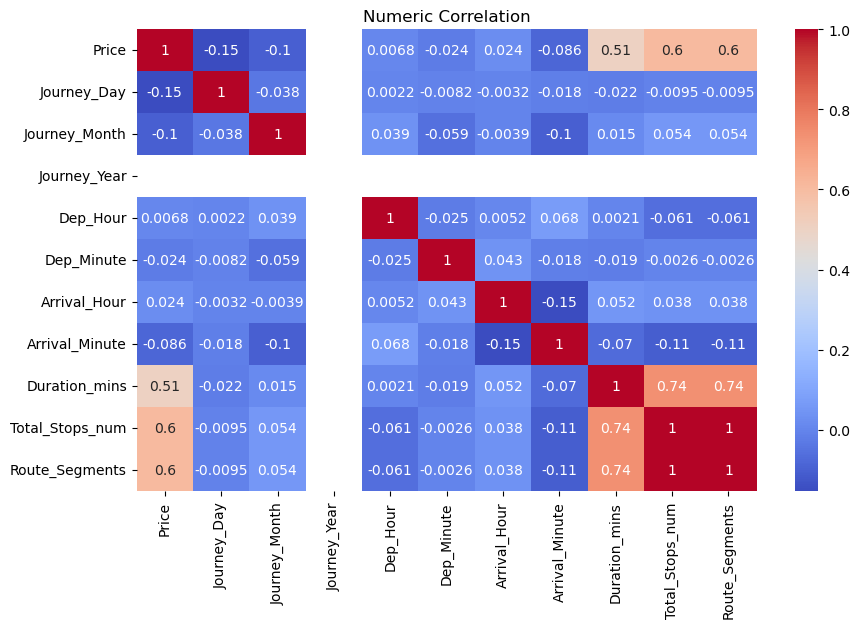

In [71]:
## EDA plots
plt.figure(figsize=(8,5))
sns.histplot(df['Price'], kde=True)
plt.title("Price distribution"); plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='Total_Stops', y='Price', data=df)
plt.title("Price vs Stops"); plt.show()

plt.figure(figsize=(12,5))
sns.barplot(x='Airline', y='Price', data=df, estimator=np.mean)
plt.xticks(rotation=90); plt.title("Average Price by Airline"); plt.show()

# Correlation of numeric features
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Numeric Correlation"); plt.show()


In [74]:
## select features
features = [
 'Airline','Source','Destination',
 'Duration_mins','Total_Stops_num','Route_Segments',
 'Journey_Day','Journey_Month',
 'Dep_Hour','Dep_Minute','Arrival_Hour','Arrival_Minute'
]
target = 'Price'

df_model = df[features + [target]].copy()
df_model.shape


(10682, 13)

In [76]:
X = df_model.drop(target, axis=1)
y = df_model[target].astype(float)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train_raw.shape, X_test_raw.shape)


(8545, 12) (2137, 12)


In [78]:
##preprocessing pipelines
numeric_cols = ['Duration_mins','Total_Stops_num','Route_Segments','Journey_Day','Journey_Month','Dep_Hour','Dep_Minute','Arrival_Hour','Arrival_Minute']
categorical_cols = ['Airline','Source','Destination']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_cols),
    ('cat', cat_pipeline, categorical_cols)
], remainder='drop')


## STEP 6 : BUILDING MODELS

### * Before Hyperparameter Tuning *

In [80]:
##define models
models = {
    'Linear': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_jobs=-1, random_state=42)
}
if XGB_AVAILABLE:
    models['XGBoost'] = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)

results = []
for name, estimator in models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('model', estimator)])
    pipe.fit(X_train_raw, y_train)
    preds = pipe.predict(X_test_raw)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results.append((name, mae, rmse, r2))
pd.DataFrame(results, columns=['Model','MAE','RMSE','R2']).sort_values('RMSE')


,Model,MAE,RMSE,R2
3,XGBoost,1122.513332,1798.451437,0.849994
2,RandomForest,1162.975577,1966.873544,0.820583
1,DecisionTree,1298.874474,2187.578760,0.778059
0,Linear,1972.878356,2863.626659,0.619686


In [86]:
##cross-val RMSE on training 
for name, estimator in [('RandomForest', RandomForestRegressor(random_state=42))]:
    pipe = Pipeline([('preprocessor', preprocessor), ('model', estimator)])
    scores = -1 * cross_val_score(pipe, X_train_raw, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    print(name, "CV RMSE mean:", np.sqrt(scores.mean()))


RandomForest CV RMSE mean: 2067.193960291798


In [88]:
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__max_depth': [8, 10, 12, 15, None],
    'model__min_samples_split': [2, 5, 10]
}

rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_params,
    n_iter=12,
    scoring='r2',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X_train_raw, y_train)

print("Best RF params:", rf_random.best_params_)



Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF params: {'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__max_depth': 15}


In [89]:
xgb_params = {
    'model__n_estimators': [200, 300, 400],
    'model__max_depth': [5, 6, 7, 8],
    'model__learning_rate': [0.05, 0.1, 0.15]
}

xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=42
    ))
])

xgb_random = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_params,
    n_iter=10,
    scoring='r2',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

xgb_random.fit(X_train_raw, y_train)

print("Best XGB params:", xgb_random.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGB params: {'model__n_estimators': 300, 'model__max_depth': 5, 'model__learning_rate': 0.1}


In [90]:
rf_best = rf_random.best_estimator_
rf_pred = rf_best.predict(X_test_raw)

print("Random Forest R2:", r2_score(y_test, rf_pred))


Random Forest R2: 0.8421460714292489


In [91]:
xgb_best = xgb_random.best_estimator_
xgb_pred = xgb_best.predict(X_test_raw)

print("XGBoost R2:", r2_score(y_test, xgb_pred))


XGBoost R2: 0.8571560691631877


### * AFTER HYPERPARAMETER TUNING *

In [102]:
# Store results
final_results = []

# 1. Linear Regression
lin_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
lin_pipe.fit(X_train_raw, y_train)
lin_pred = lin_pipe.predict(X_test_raw)

final_results.append([
    'Linear Regression',
    mean_absolute_error(y_test, lin_pred),
    np.sqrt(mean_squared_error(y_test, lin_pred)),
    r2_score(y_test, lin_pred)
])


# 2. Decision Tree 
dt_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])
dt_pipe.fit(X_train_raw, y_train)
dt_pred = dt_pipe.predict(X_test_raw)

final_results.append([
    'Decision Tree',
    mean_absolute_error(y_test, dt_pred),
    np.sqrt(mean_squared_error(y_test, dt_pred)),
    r2_score(y_test, dt_pred)
])


# 3. Random Forest (TUNED)
rf_best = rf_random.best_estimator_
rf_pred = rf_best.predict(X_test_raw)

final_results.append([
    'Random Forest (Tuned)',
    mean_absolute_error(y_test, rf_pred),
    np.sqrt(mean_squared_error(y_test, rf_pred)),
    r2_score(y_test, rf_pred)
])


# 4. XGBoost (TUNED)
xgb_best = xgb_random.best_estimator_
xgb_pred = xgb_best.predict(X_test_raw)

final_results.append([
    'XGBoost (Tuned)',
    mean_absolute_error(y_test, xgb_pred),
    np.sqrt(mean_squared_error(y_test, xgb_pred)),
    r2_score(y_test, xgb_pred)
])


# FINAL TABLE
final_table = pd.DataFrame(final_results, columns=['Model', 'MAE', 'RMSE', 'R2'])

final_table.sort_values('RMSE')


,Model,MAE,RMSE,R2
3,XGBoost (Tuned),1169.076534,1754.995408,0.857156
2,Random Forest (Tuned),1122.303320,1844.899807,0.842146
1,Decision Tree,1298.874474,2187.578760,0.778059
0,Linear Regression,1972.878356,2863.626659,0.619686
